<a href="https://colab.research.google.com/github/GazalaSayyad/Handwritten-recognition-using-Pytorch/blob/master/Handwritten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing required Packages

In [0]:
import torch
import torch. nn as nn
import torch.nn.functional as F
import torch. optim as optim
from torchvision import datasets , transforms

Importing Python packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

 Initializing CUDA

In [7]:
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

Using PyTorch version: 1.4.0 CUDA: False


In [8]:
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [0]:
batch_size = 32

Load MNIST data

In [0]:
%ls ../data/MNIST/raw/train-images-idx3-ubyte

In [12]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, 
)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True,
   )

The first element of training data (X_train) is a 4th-order tensor of size (batch_size, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. y_train is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.



In [17]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Plotting the first 10 training digits

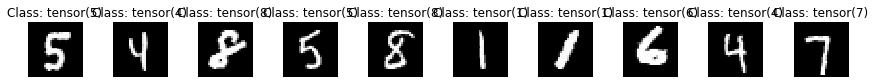

In [38]:
pltsize=1
plt.figure(figsize=(15*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i, : , : , :].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '  +  str(y_train[i]))

 Neural network and optimizer

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)   


In [0]:
model = Net()
model = model.to(device)

In [32]:
model

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

Optimizer 

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [0]:
def train(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
       
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [0]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).to(device).sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [37]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs +
                   1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.339864
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.180570
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.799203
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.561847
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.573012
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.515539
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.866030
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.344470
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.417101
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.396113
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.247822
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.147522
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.436234
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.373817
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.203475
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.566010
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.270142
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.346352
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.304885

Test set: Average loss: 0.2289, Accuracy: 9305/10000 (93%)

Evaluating the Model's Performance

Text(0, 0.5, 'error')

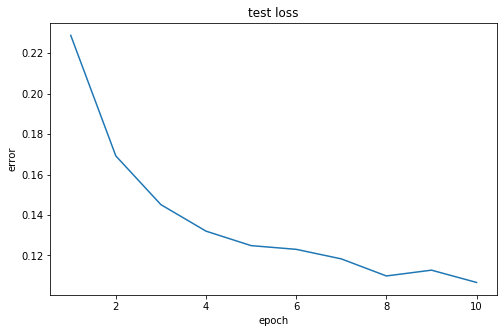

In [39]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('test loss')
plt.xlabel("epoch")
plt.ylabel("error")